In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense

In [2]:
df = pd.read_csv("Space Travel.csv")

In [3]:
df.head()

,Unnamed: 0,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,Travel company,Name,VIP,RoomService,FoodCourt,Travel Outcome
0,0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,Tulsa Inc,Maham Ofracculy,False,0.0,0.0,Succesfully reached Destination
1,1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,Blue Horizon,Juanna Vines,False,109.0,9.0,Succesfully reached Destination
2,2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,Blue Horizon,Altark Susent,True,43.0,3576.0,Reached wrong destination
3,3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,Tulsa Inc,Solam Susent,False,0.0,1283.0,Succesfully reached Destination
4,4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,Blue Horizon,Willy Santantines,False,303.0,70.0,Succesfully reached Destination


## _Performing EDA_

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      8693 non-null   int64  
 1   PassengerId     8693 non-null   object 
 2   HomePlanet      8492 non-null   object 
 3   CryoSleep       8476 non-null   object 
 4   Cabin           8494 non-null   object 
 5   Destination     8511 non-null   object 
 6   Age             8514 non-null   float64
 7   Travel company  8693 non-null   object 
 8   Name            8493 non-null   object 
 9   VIP             8490 non-null   object 
 10  RoomService     8512 non-null   float64
 11  FoodCourt       8510 non-null   float64
 12  Travel Outcome  8693 non-null   object 
dtypes: float64(3), int64(1), object(9)
memory usage: 883.0+ KB


In [5]:
df.describe()

,Unnamed: 0,Age,RoomService,FoodCourt
count,8693.000000,8514.000000,8512.000000,8510.000000
mean,4346.000000,28.827930,224.687617,458.077203
std,2509.597278,14.489021,666.717663,1611.489240
min,0.000000,0.000000,0.000000,0.000000
25%,2173.000000,19.000000,0.000000,0.000000
50%,4346.000000,27.000000,0.000000,0.000000
75%,6519.000000,38.000000,47.000000,76.000000
max,8692.000000,79.000000,14327.000000,29813.000000


#### We can say that 'Unnamed: 0','PassengerId','Name' these columns can be dropped 

In [6]:
df.drop(['Unnamed: 0','PassengerId','Name'],inplace=True,axis=1)

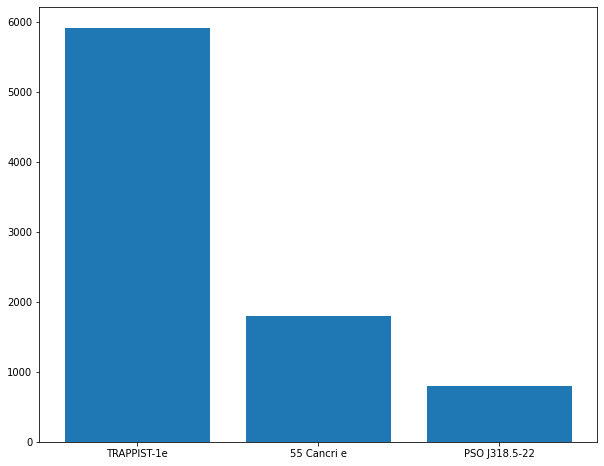

In [7]:
def unique_plot(df,col_name,chart='bar'):
    plot = plt.figure(figsize=(10,8))
    if chart == 'bar':
        plt.bar(list(df[col_name].value_counts().index),list(df[col_name].value_counts().values))
        plt.show()
    elif chart == 'pie':
        plt.pie(list(df[col_name].value_counts().values),labels=list(df[col_name].value_counts().index))
    else:
        return 'Invalid plot parameter'
unique_plot(df,'Destination','bar')

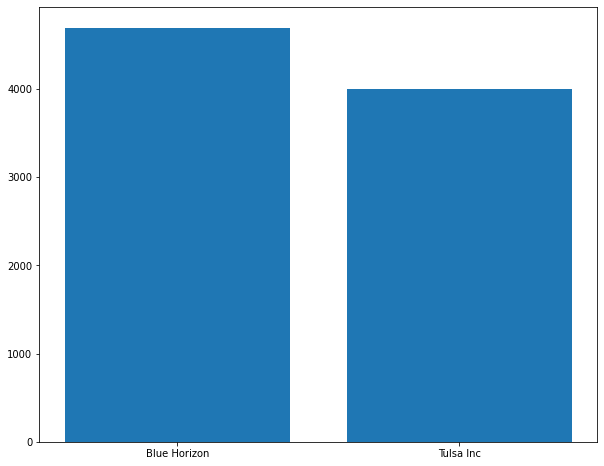

In [8]:
unique_plot(df,'Travel company','bar')

In [9]:
df.isnull().sum()

HomePlanet        201
CryoSleep         217
Cabin             199
Destination       182
Age               179
Travel company      0
VIP               203
RoomService       181
FoodCourt         183
Travel Outcome      0
dtype: int64

In [10]:
def percent_unll(df):
    return str((df.isnull().sum() * 100 / len(df)).sum()) + '% data is null'
percent_unll(df)

'17.772920740825953% data is null'

#### Since 17.77% data is null, there is a need to handle the null values

## _Data Preprocessing - Handling null values_ 

#### Handling null values in Cabin column

In [11]:
df['Cabin'].fillna('-1/-1/-1',inplace=True)

In [12]:
df[['Cols','Seat_number','P_S']] = df.Cabin.str.split("/",expand=True)

In [13]:
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,Travel company,VIP,RoomService,FoodCourt,Travel Outcome,Cols,Seat_number,P_S
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,Tulsa Inc,False,0.0,0.0,Succesfully reached Destination,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,Blue Horizon,False,109.0,9.0,Succesfully reached Destination,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,Blue Horizon,True,43.0,3576.0,Reached wrong destination,A,0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,Tulsa Inc,False,0.0,1283.0,Succesfully reached Destination,A,0,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,Blue Horizon,False,303.0,70.0,Succesfully reached Destination,F,1,S


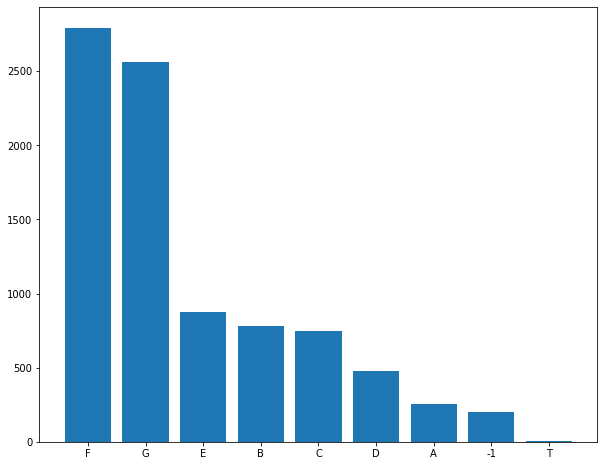

In [14]:
unique_plot(df,'Cols','bar')

Replacing the null values with the mode of the column

In [15]:
def replace_data(df,col_name,method=None,to_replace=None):
    if method == 'mean':
        value = df[col_name].mean()
    elif method == 'mode':
        value = df[col_name].mode().loc[0]
    if to_replace != None:
        df[col_name].replace(to_replace=to_replace,value=value,inplace=True)
    else:
        df[col_name].fillna(value,inplace=True)

In [16]:
replace_data(df,'Cols',to_replace='-1',method='mode')

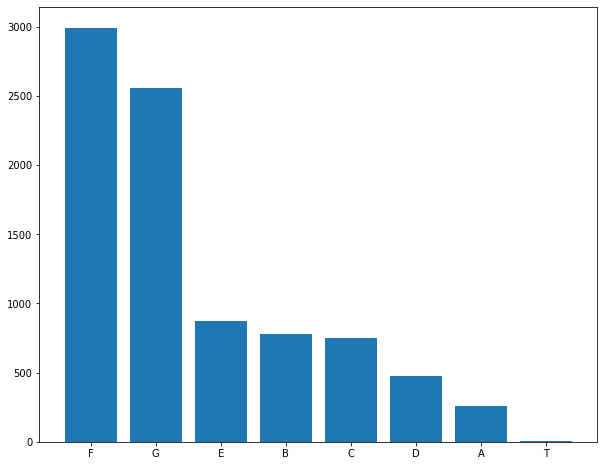

In [17]:
unique_plot(df,'Cols','bar')

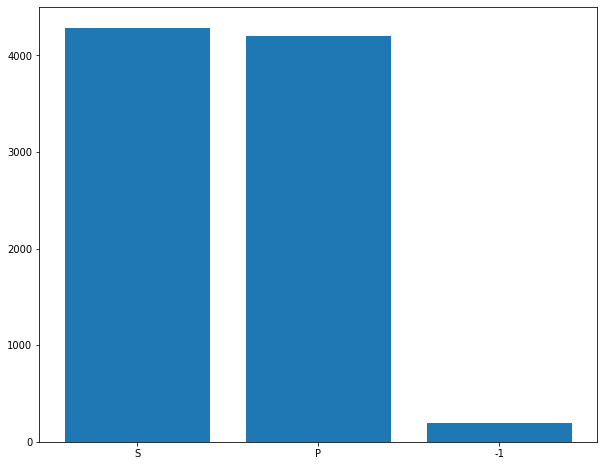

In [18]:
unique_plot(df,'P_S','bar')

Since both value counts are nearly same...Replacing values of P_S randomly

In [19]:
choices = df.P_S.unique().tolist()[:-1]
df.loc[df['P_S'] == '-1', 'P_S'] = random.choice(choices)

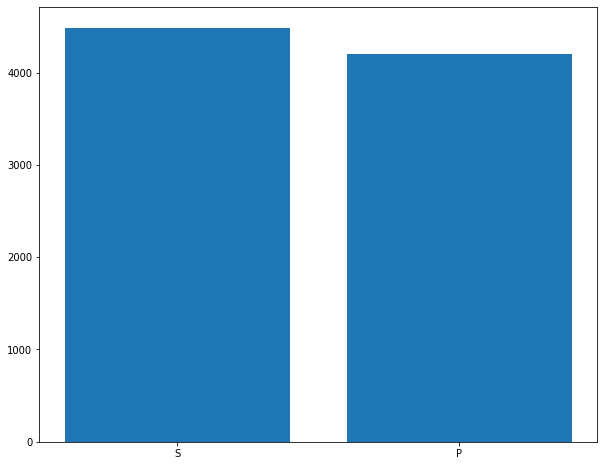

In [20]:
unique_plot(df,'P_S','bar')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HomePlanet      8492 non-null   object 
 1   CryoSleep       8476 non-null   object 
 2   Cabin           8693 non-null   object 
 3   Destination     8511 non-null   object 
 4   Age             8514 non-null   float64
 5   Travel company  8693 non-null   object 
 6   VIP             8490 non-null   object 
 7   RoomService     8512 non-null   float64
 8   FoodCourt       8510 non-null   float64
 9   Travel Outcome  8693 non-null   object 
 10  Cols            8693 non-null   object 
 11  Seat_number     8693 non-null   object 
 12  P_S             8693 non-null   object 
dtypes: float64(3), object(10)
memory usage: 883.0+ KB


In [22]:
# unique_plot(df,'Seat_number','pie')

In [23]:
df.Seat_number.value_counts()


-1      199
82       28
19       22
86       22
97       21
       ... 
1549      1
1837      1
1057      1
1651      1
1367      1
Name: Seat_number, Length: 1818, dtype: int64

As the count of missing values is too much as compared to other values..we can drop this column

In [24]:
df.drop(['Cabin','Seat_number'],inplace=True,axis=1)

In [25]:
df.head()

,HomePlanet,CryoSleep,Destination,Age,Travel company,VIP,RoomService,FoodCourt,Travel Outcome,Cols,P_S
0,Europa,False,TRAPPIST-1e,39.0,Tulsa Inc,False,0.0,0.0,Succesfully reached Destination,B,P
1,Earth,False,TRAPPIST-1e,24.0,Blue Horizon,False,109.0,9.0,Succesfully reached Destination,F,S
2,Europa,False,TRAPPIST-1e,58.0,Blue Horizon,True,43.0,3576.0,Reached wrong destination,A,S
3,Europa,False,TRAPPIST-1e,33.0,Tulsa Inc,False,0.0,1283.0,Succesfully reached Destination,A,S
4,Earth,False,TRAPPIST-1e,16.0,Blue Horizon,False,303.0,70.0,Succesfully reached Destination,F,S


In [26]:
df.isnull().sum()

HomePlanet        201
CryoSleep         217
Destination       182
Age               179
Travel company      0
VIP               203
RoomService       181
FoodCourt         183
Travel Outcome      0
Cols                0
P_S                 0
dtype: int64

#### Handling null values in HomePLanet column

In [27]:
df.HomePlanet.value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

Replacing null values in HomePlanet with mode of the column

In [28]:
replace_data(df,'HomePlanet',method='mode')

In [29]:
df.isnull().sum()

HomePlanet          0
CryoSleep         217
Destination       182
Age               179
Travel company      0
VIP               203
RoomService       181
FoodCourt         183
Travel Outcome      0
Cols                0
P_S                 0
dtype: int64

#### Handling null values in CryoSleep column

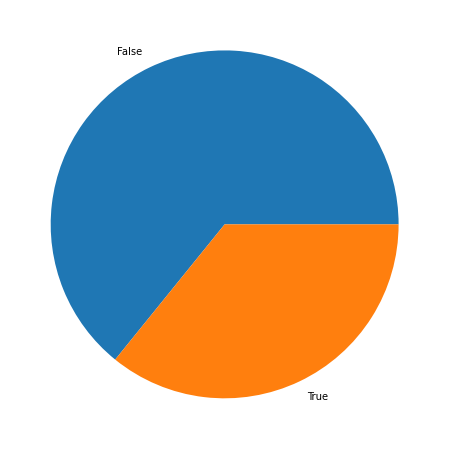

In [30]:
unique_plot(df,'CryoSleep','pie')

Replacing null values in CryoSleep with mode of the column

In [31]:
replace_data(df,'CryoSleep',method='mode')

In [32]:
df.isnull().sum()

HomePlanet          0
CryoSleep           0
Destination       182
Age               179
Travel company      0
VIP               203
RoomService       181
FoodCourt         183
Travel Outcome      0
Cols                0
P_S                 0
dtype: int64

#### Handling null values in Destination column

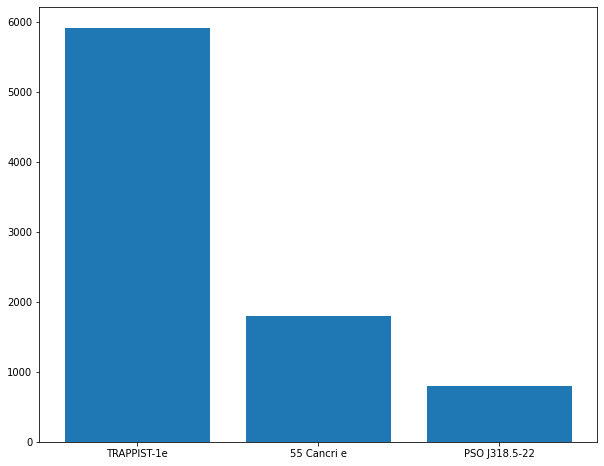

In [33]:
unique_plot(df,'Destination','bar')

In [34]:
replace_data(df,'Destination',method='mode')

In [35]:
df.isna().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age               179
Travel company      0
VIP               203
RoomService       181
FoodCourt         183
Travel Outcome      0
Cols                0
P_S                 0
dtype: int64

#### Handling null values in Destination column

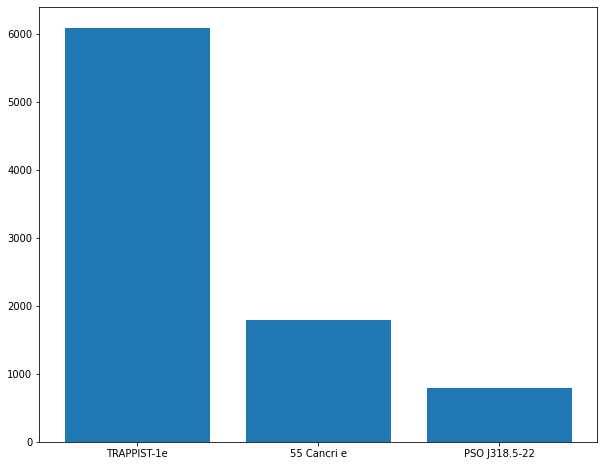

In [36]:
unique_plot(df,'Destination','bar')

In [37]:
replace_data(df,'Destination',method='mode')

In [38]:
df.isna().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age               179
Travel company      0
VIP               203
RoomService       181
FoodCourt         183
Travel Outcome      0
Cols                0
P_S                 0
dtype: int64

#### Handling null values in Age column

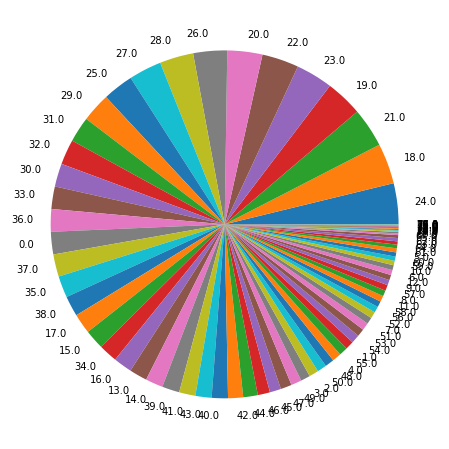

In [39]:
unique_plot(df,'Age','pie')

In [40]:
replace_data(df,'Age',method='mean')

In [41]:
df.isna().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
Travel company      0
VIP               203
RoomService       181
FoodCourt         183
Travel Outcome      0
Cols                0
P_S                 0
dtype: int64

#### Handling null values in Destination column

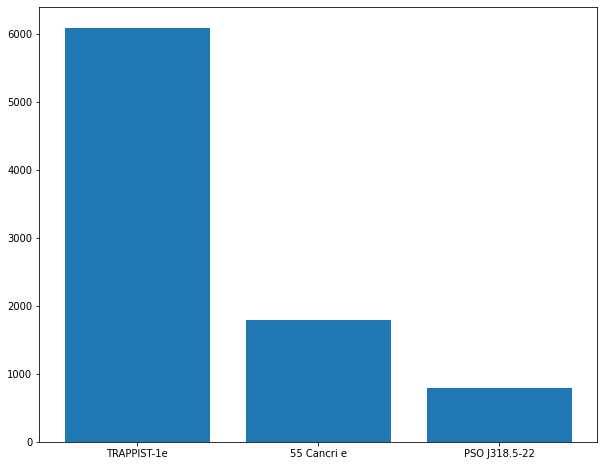

In [42]:
unique_plot(df,'Destination','bar')

In [43]:
replace_data(df,'Destination',method='mode')

In [44]:
df.isna().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
Travel company      0
VIP               203
RoomService       181
FoodCourt         183
Travel Outcome      0
Cols                0
P_S                 0
dtype: int64

#### Handling null values in VIP column

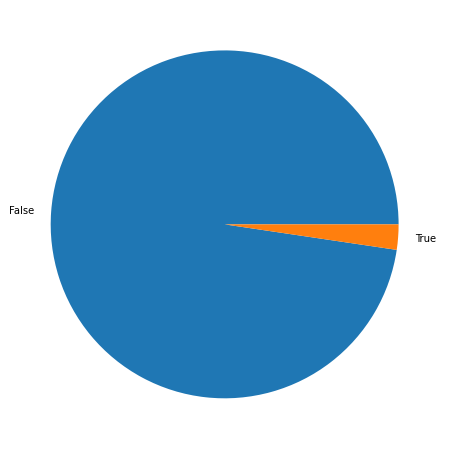

In [45]:
unique_plot(df,'VIP','pie')

In [46]:
replace_data(df,'VIP',method='mode')

In [47]:
df.isna().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
Travel company      0
VIP                 0
RoomService       181
FoodCourt         183
Travel Outcome      0
Cols                0
P_S                 0
dtype: int64

#### Handling null values in RoomService column

In [48]:
replace_data(df,'RoomService',method='mean')

In [49]:
df.isna().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
Travel company      0
VIP                 0
RoomService         0
FoodCourt         183
Travel Outcome      0
Cols                0
P_S                 0
dtype: int64

#### Handling null values in FoodCourt column

In [50]:
replace_data(df,'FoodCourt',method='mean')

In [51]:
df.isna().sum()

HomePlanet        0
CryoSleep         0
Destination       0
Age               0
Travel company    0
VIP               0
RoomService       0
FoodCourt         0
Travel Outcome    0
Cols              0
P_S               0
dtype: int64

#### "Reached wrong destination" is as good as "Failed to reach" .. thus replace it with "Failed to reach"

In [52]:
df['Travel Outcome'].replace(to_replace='Reached wrong destination',value='Failed to reach',inplace=True)
df['Travel Outcome'].unique()

array(['Succesfully reached Destination', 'Failed to reach'], dtype=object)

## _Data Preprocessing - Handling categorical variables_ 

In [53]:
df

,HomePlanet,CryoSleep,Destination,Age,Travel company,VIP,RoomService,FoodCourt,Travel Outcome,Cols,P_S
0,Europa,False,TRAPPIST-1e,39.0,Tulsa Inc,False,0.0,0.0,Succesfully reached Destination,B,P
1,Earth,False,TRAPPIST-1e,24.0,Blue Horizon,False,109.0,9.0,Succesfully reached Destination,F,S
2,Europa,False,TRAPPIST-1e,58.0,Blue Horizon,True,43.0,3576.0,Failed to reach,A,S
3,Europa,False,TRAPPIST-1e,33.0,Tulsa Inc,False,0.0,1283.0,Succesfully reached Destination,A,S
4,Earth,False,TRAPPIST-1e,16.0,Blue Horizon,False,303.0,70.0,Succesfully reached Destination,F,S
...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,Blue Horizon,True,0.0,6819.0,Failed to reach,A,P
8689,Earth,True,PSO J318.5-22,18.0,Blue Horizon,False,0.0,0.0,Succesfully reached Destination,G,S
8690,Earth,False,TRAPPIST-1e,26.0,Blue Horizon,False,0.0,0.0,Failed to reach,G,S
8691,Europa,False,55 Cancri e,32.0,Blue Horizon,False,0.0,1049.0,Failed to reach,E,S


In [54]:
def map_encodings(df,col_name):
    vals = df[col_name].unique().tolist()
    maps = dict()
    for i,j in enumerate(vals):
        maps[j] = i
    print(maps)
    df[col_name] = df[col_name].map(maps)

In [55]:
map_encodings(df,'HomePlanet')

{'Europa': 0, 'Earth': 1, 'Mars': 2}


In [56]:
map_encodings(df,'CryoSleep')

{False: 0, True: 1}


In [57]:
map_encodings(df,'Destination')

{'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2}


In [58]:
map_encodings(df,'Travel company')

{'Tulsa Inc': 0, 'Blue Horizon': 1}


In [59]:
map_encodings(df,'VIP')

{False: 0, True: 1}


In [60]:
map_encodings(df,'Travel Outcome')

{'Succesfully reached Destination': 0, 'Failed to reach': 1}


In [61]:
map_encodings(df,'Cols')

{'B': 0, 'F': 1, 'A': 2, 'G': 3, 'E': 4, 'D': 5, 'C': 6, 'T': 7}


In [62]:
map_encodings(df,'P_S')

{'P': 0, 'S': 1}


In [63]:
df.head(10)

,HomePlanet,CryoSleep,Destination,Age,Travel company,VIP,RoomService,FoodCourt,Travel Outcome,Cols,P_S
0,0,0,0,39.0,0,0,0.0,0.0,0,0,0
1,1,0,0,24.0,1,0,109.0,9.0,0,1,1
2,0,0,0,58.0,1,1,43.0,3576.0,1,2,1
3,0,0,0,33.0,0,0,0.0,1283.0,0,2,1
4,1,0,0,16.0,1,0,303.0,70.0,0,1,1
5,1,0,1,44.0,0,0,0.0,483.0,0,1,0
6,1,0,0,26.0,0,0,42.0,1539.0,1,1,1
7,1,1,0,28.0,0,0,0.0,0.0,1,3,1
8,1,0,0,35.0,1,0,0.0,785.0,1,1,1
9,0,1,2,14.0,0,0,0.0,0.0,1,0,0


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HomePlanet      8693 non-null   int64  
 1   CryoSleep       8693 non-null   int64  
 2   Destination     8693 non-null   int64  
 3   Age             8693 non-null   float64
 4   Travel company  8693 non-null   int64  
 5   VIP             8693 non-null   int64  
 6   RoomService     8693 non-null   float64
 7   FoodCourt       8693 non-null   float64
 8   Travel Outcome  8693 non-null   int64  
 9   Cols            8693 non-null   int64  
 10  P_S             8693 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 747.2 KB


In [65]:
# df.drop(['Age','Cols'],inplace=True,axis=1)

## Saving the CSV

In [66]:
df.to_csv('preprocessed.csv')

## Modelling

#### Splitting data in train and test data

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
y = df['Travel Outcome']
X = df.drop(['Travel Outcome'],axis=1)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6954, 10), (1739, 10), (6954,), (1739,))

#### Data Standardization

In [70]:
from sklearn.preprocessing import StandardScaler

In [71]:
sc = StandardScaler().fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_test_std

array([[-1.42728927, -0.72757131, -0.61759957, ..., -0.19929973,
        -0.27306275,  0.96968561],
       [-1.42728927, -0.72757131,  1.83867004, ...,  5.97310964,
        -1.41731003, -1.03126208],
       [ 0.06974988, -0.72757131, -0.61759957, ..., -0.28755692,
        -0.84518639,  0.96968561],
       ...,
       [ 1.56678903, -0.72757131, -0.61759957, ..., -0.28755692,
        -0.84518639, -1.03126208],
       [-1.42728927, -0.72757131, -0.61759957, ...,  1.73800769,
        -1.41731003,  0.96968561],
       [ 0.06974988, -0.72757131, -0.61759957, ..., -0.28755692,
        -0.84518639,  0.96968561]])

### Logistic regression

In [72]:
model = LogisticRegression()

In [73]:
model.fit(X_train_std,y_train)
y_test_pred = model.predict(X_test_std)
y_train_pred = model.predict(X_train_std)
y_train_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [74]:
model.score(X_test,y_test)

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.5434157561817137

In [75]:
accuracy_score(y_train, y_train_pred)

0.6571757262007478

In [76]:
accuracy_score(y_test, y_test_pred)

0.6457734330074756

In [77]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       616
           1       0.65      1.00      0.78      1123

    accuracy                           0.65      1739
   macro avg       0.32      0.50      0.39      1739
weighted avg       0.42      0.65      0.51      1739



D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVM

In [78]:
clf = SVC()
# clf = SVC(probability=True)

In [79]:
clf.fit(X_train_std,y_train)
y_test_pred = clf.predict(X_test_std)
y_train_pred = clf.predict(X_train_std)
# y_test_pred = clf.predict_proba(X_test_std)
# y_train_pred = clf.predict_proba(X_train_std)
y_train_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [80]:
clf.score(X_test,y_test)

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


0.6457734330074756

In [81]:
accuracy_score(y_train, y_train_pred)

0.6609145815358067

In [82]:
accuracy_score(y_test, y_test_pred)

0.6451983898792409

In [83]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.33      0.00      0.00       616
           1       0.65      1.00      0.78      1123

    accuracy                           0.65      1739
   macro avg       0.49      0.50      0.39      1739
weighted avg       0.54      0.65      0.51      1739



### Random forest

In [84]:
model = RandomForestClassifier()

In [85]:
model.fit(X_train_std,y_train)
y_test_pred = model.predict(X_test_std)
y_train_pred = model.predict(X_train_std)
y_train_pred

array([1, 0, 0, ..., 1, 0, 1], dtype=int64)

In [86]:
model.score(X_test,y_test)

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.5480161012075906

In [87]:
accuracy_score(y_train, y_train_pred)

0.9354328444060972

In [88]:
accuracy_score(y_test, y_test_pred)

0.5830937320299022

In [89]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.36      0.22      0.27       616
           1       0.65      0.78      0.71      1123

    accuracy                           0.58      1739
   macro avg       0.50      0.50      0.49      1739
weighted avg       0.54      0.58      0.55      1739



### Xg boost

In [90]:
model = XGBClassifier(use_label_encoder=False)

In [91]:
model.fit(X_train_std,y_train)
y_test_pred = model.predict(X_test_std)
y_train_pred = model.predict(X_train_std)
y_train_pred

[22:03:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([1, 1, 1, ..., 1, 1, 1])

In [92]:
model.score(X_test,y_test)

0.43128234617596317

In [93]:
accuracy_score(y_train, y_train_pred)

0.7796951394880645

In [94]:
accuracy_score(y_test, y_test_pred)

0.6233467510063255

### Deel learning

In [95]:
model = Sequential()
model.add(Dense(20, input_shape=(10,), activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [96]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [97]:
X_train_std.shape, y_train.shape

((6954, 10), (6954,))

In [98]:
model.fit(X_train_std, y_train, epochs=150, batch_size=10,verbose=1)

Epoch 1/150
696/696 [==============================] - 2s 788us/step - loss: 0.6567 - accuracy: 0.6378
Epoch 2/150
696/696 [==============================] - 1s 736us/step - loss: 0.6491 - accuracy: 0.6479
Epoch 3/150
696/696 [==============================] - 0s 688us/step - loss: 0.6435 - accuracy: 0.65400s - loss: 0.6444 - accura
Epoch 4/150
696/696 [==============================] - 0s 692us/step - loss: 0.6378 - accuracy: 0.6622
Epoch 5/150
696/696 [==============================] - 1s 746us/step - loss: 0.6369 - accuracy: 0.6631
Epoch 6/150
696/696 [==============================] - 0s 663us/step - loss: 0.6430 - accuracy: 0.6513
Epoch 7/150
696/696 [==============================] - 1s 726us/step - loss: 0.6386 - accuracy: 0.6577
Epoch 8/150
696/696 [==============================] - 0s 699us/step - loss: 0.6346 - accuracy: 0.6635
Epoch 9/150
696/696 [==============================] - 0s 705us/step - loss: 0.6309 - accuracy: 0.6676
Epoch 10/150
696/696 [=========================

696/696 [==============================] - 1s 724us/step - loss: 0.6223 - accuracy: 0.66270s - loss: 0.6260 - accuracy: 0.65 - ETA: 0s - loss: 0.6244 - accuracy
Epoch 80/150
696/696 [==============================] - 1s 787us/step - loss: 0.6188 - accuracy: 0.6647
Epoch 81/150
696/696 [==============================] - 1s 769us/step - loss: 0.6196 - accuracy: 0.6623
Epoch 82/150
696/696 [==============================] - 0s 708us/step - loss: 0.6138 - accuracy: 0.6726
Epoch 83/150
696/696 [==============================] - 0s 688us/step - loss: 0.6169 - accuracy: 0.6640
Epoch 84/150
696/696 [==============================] - 0s 710us/step - loss: 0.6111 - accuracy: 0.6724
Epoch 85/150
696/696 [==============================] - 0s 692us/step - loss: 0.6187 - accuracy: 0.6714
Epoch 86/150
696/696 [==============================] - 1s 750us/step - loss: 0.6160 - accuracy: 0.6635
Epoch 87/150
696/696 [==============================] - 0s 657us/step - loss: 0.6184 - accuracy: 0.6686
Epoch 8

In [99]:
_, accuracy = model.evaluate(X_train_std, y_train)
print('Accuracy: %.2f' % (accuracy*100))

218/218 [==============================] - 0s 599us/step - loss: 0.6027 - accuracy: 0.6798
Accuracy: 67.98


In [100]:
model.save('keras_model.h5')

In [101]:
def get_model_predictions(x_train, y_train, X, model_name='SVM', model_object=None):
    replace_encoding = lambda x: 'Succesfully reached Destination' if x>0.5 else 'Failed to reach'
    if model_name == 'SVM':
        model = SVC(probability=True)
        model.fit(x_train,y_train)
        y = model.predict_proba(X.reshape(1,-1))
        outcome = y[0][1]
        return outcome, replace_encoding(outcome)
    elif model_name == 'logreg':
        model = LogisticRegression()
        model.fit(x_train,y_train)
        y = model.predict_proba(X.reshape(1,-1))
        outcome = y[0][1]
        return outcome, replace_encoding(outcome)
    elif model_name == 'randomforest':
        model = RandomForestClassifier()
        model.fit(x_train,y_train)
        y = model.predict_proba(X.reshape(1,-1))
        outcome = y[0][1]
        return outcome, replace_encoding(outcome)
    elif model_name == 'xgboost':
        model = XGBClassifier()
        model.fit(x_train,y_train)
        y = model.predict_proba(X.reshape(1,-1))
        outcome = y[0][1]
        return outcome, replace_encoding(outcome)
    elif model_name == 'dnn':
        model = model = load_model('keras_model.h5')
        y = model.predict(X.reshape(1,-1))
        outcome = y[0][0]
        return outcome, replace_encoding(outcome)

In [102]:
# x = np.array([0,0,0,58.0,1,1,43.0,3576.0,2,1])
x = np.array([0,0,0,33.0,0,0,0.0,1283.0,2,1])

In [103]:
get_model_predictions(X_train_std,y_train,x,model_name='logreg')

(1.0, 'Succesfully reached Destination')

In [104]:
def encode_input(home_planet, cyro, dest, age,travel_company, vip, room_service, food_court, cols, p_s):
    context = {
        'HomePlanet' : {'Europa': 0, 'Earth': 1, 'Mars': 2},
        'CryoSleep' : {False: 0, True: 1},
        'Destination' : {'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2},
        'Travel_company' : {'Tulsa Inc': 0, 'Blue Horizon': 1},
        'P_S' : {'P': 0, 'S': 1},
        'Cols' : {'B': 0, 'F': 1, 'A': 2, 'G': 3, 'E': 4, 'D': 5, 'C': 6, 'T': 7},
        'VIP' : {False: 0, True: 1},
    }
    home_planet_en = context['HomePlanet'][home_planet]
    cyro_en = context['CryoSleep'][cyro]
    dest_en = context['Destination'][dest]
    travel_company_en = context['Travel_company'][travel_company]
    p_s_en = context['P_S'][p_s]
    cols_en = context['Cols'][cols]
    vip_en = context['VIP'][vip]
    
    inp = np.array([home_planet_en, cyro_en, dest_en, age,travel_company_en, vip_en, room_service, food_court, cols_en, p_s_en])
    return inp

In [105]:
x1 = encode_input(home_planet='Earth', cyro=False, dest='TRAPPIST-1e', age=34, travel_company='Tulsa Inc', vip=False, room_service=43.0, food_court=40, cols='B', p_s='P')